In [1]:
from get_embedding import get_embedding
from diffusion import *
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap

import os
import glob
import random
import time
import sys
import importlib
import collections

In [2]:

# Todo
# Set Parameters:

n_neighbors=100
step=(60,60)

grid=(20,20)
dt = 0.01
t_total = 10000
n_repeats = 20

detail_result_path = '/Users/pengzhizhang/Documents/test_data/Gastrulation/velocity_result'
output_path = detail_result_path
raw_data_path = '/Users/pengzhizhang/Documents/test_data/Gastrulation/raw_data'



In [3]:
load_raw_data = pd.read_csv(os.path.join(raw_data_path, 'mouse_endo_blood20to25_2000_genes_moment100.csv'))

In [4]:
detail_files = glob.iglob(os.path.join(detail_result_path, 'result_detailcsv/*/*/detail*.csv'))
lcd = list()
for f in detail_files:
    load_cellDancer_temp = pd.read_csv(f)
    load_cellDancer_temp.rename(columns = {'Unnamed: 0':'cellIndex'}, inplace = True)
    load_cellDancer_temp = load_cellDancer_temp.sort_values(by = ['gene_name', 'cellIndex'], ascending = [True, True])
    lcd.append(load_cellDancer_temp)
load_cellDancer = pd.concat(lcd)

In [5]:
gene_choice=list(set(load_cellDancer.gene_name))

embedding, sampling_ixs, velocity_embedding = get_embedding(
    load_raw_data=load_raw_data, 
    load_cellDancer=load_cellDancer, 
    gene_list=gene_choice,
    mode="gene",
    n_neighbors=n_neighbors,
    step=step)

neighbors
tranfer mode: None
None
using gene mode
(2000, 12329)
(2000, 12329)


/Users/pengzhizhang/cellDancer-activate/src/get_embedding.py:50: RuntimeWarning: invalid value encountered in true_divide
  np.sqrt(np.dot(ematrix_ss[:, None], vmatrix_ss[None]))


[]
[]


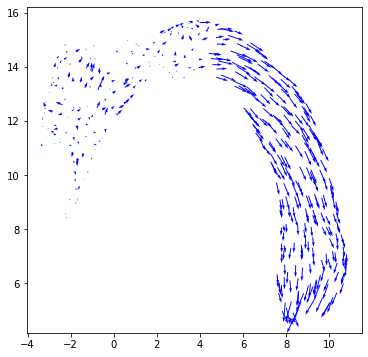

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
#plt.scatter(embedding[:, 0],embedding[:, 1], c="Silver", s=5, alpha=1)
plt.quiver(embedding[sampling_ixs, 0],embedding[sampling_ixs, 1],
          velocity_embedding[:,0], velocity_embedding[:,1], color='Blue')
plt.show()

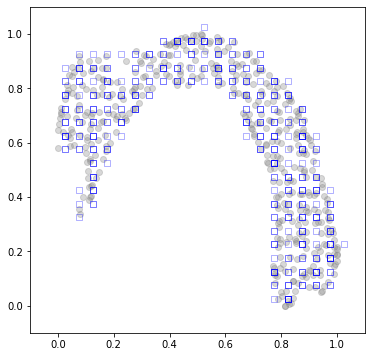

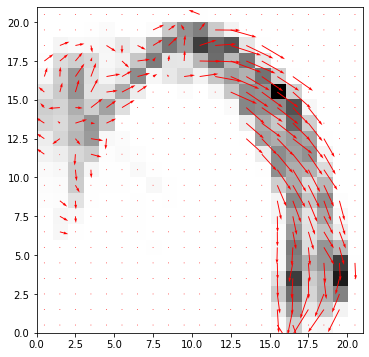

In [7]:
cell_embedding, normalized_embedding = embedding_normalization(
    embedding[sampling_ixs], embedding, mode='minmax', NORM_ALL_CELLS=True)

velocity = velocity_normalization(velocity_embedding, mode='max')

vel_mesh, grid_density, cell_grid_idx, cell_grid_coor, all_grid_idx, all_grid_coor = \
generate_grid(cell_embedding, normalized_embedding, velocity, steps=grid)
plot_mesh_velocity(vel_mesh, grid_density)

In [20]:
start_time = time.time()
paths = run_diffusion(cell_embedding, vel_mesh, grid_density, dt=dt, t_total=t_total, 
                      eps=1e-5, off_cell_init=False, n_repeats = n_repeats, n_jobs = mp.cpu_count()-1) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 144.9979100227356 seconds ---


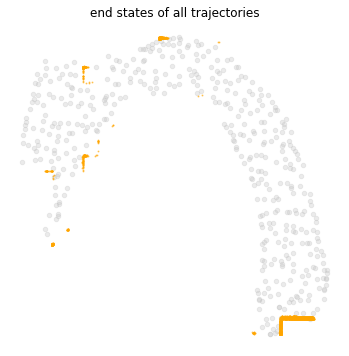

Currently  0 clusters:	 8428 paths to be categorized
Currently  1 clusters:	 0 paths to be categorized


In [21]:
newPaths = truncate_end_state_stuttering(paths, cell_embedding)
traj_displacement = np.array([compute_trajectory_displacement(ipath) for ipath in newPaths])
# sorted from long to short
order = np.argsort(traj_displacement)[::-1]
sorted_traj = newPaths[order]
traj_displacement=traj_displacement[order]


path_clusters = list()
cell_clusters = list()
path_clusters, cell_clusters = path_clustering(path_clusters, cell_clusters, 
    sorted_traj, traj_displacement, 100, 0, nkeep=10)

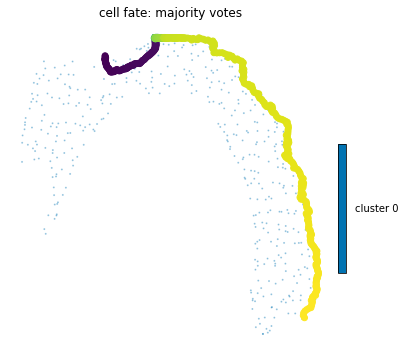



MAX allowed zero time cells are:  21
Only  1  Cells left. Stopping.

All intra cluster cell time has been resolved.




Plotting cluster internal time



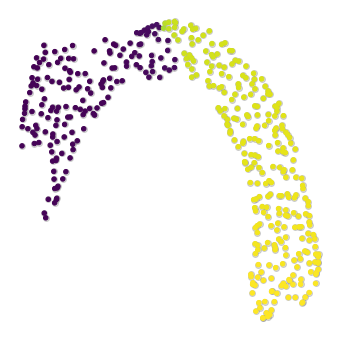

[0]


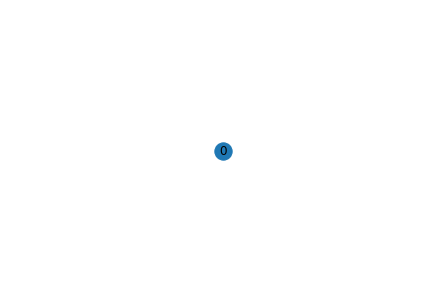




Plotting estimated pseudotime for all cells ...


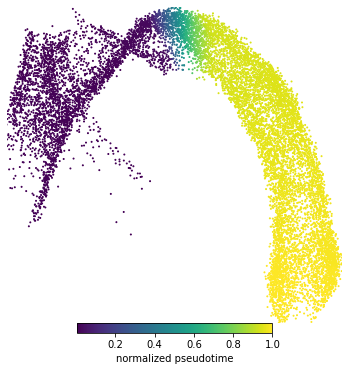

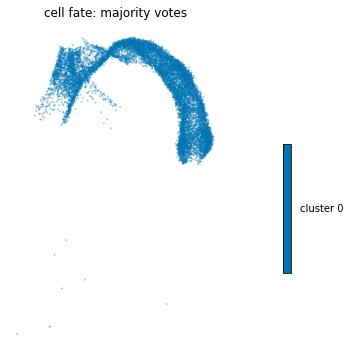

In [24]:
importlib.reload(sys.modules['diffusion'])
from diffusion import *
                 
all_cell_time = compute_all_cell_time(
    load_cellDancer,
    embedding, cell_embedding, path_clusters, cell_clusters, 
    vel_mesh, cell_grid_idx=cell_grid_idx, grid_density=grid_density, 
    sampling_ixs=sampling_ixs, step=step,
    dt=dt, t_total=t_total, n_repeats = n_repeats, 
    n_jobs=mp.cpu_count()-1, outfile=None)

<AxesSubplot:ylabel='Count'>

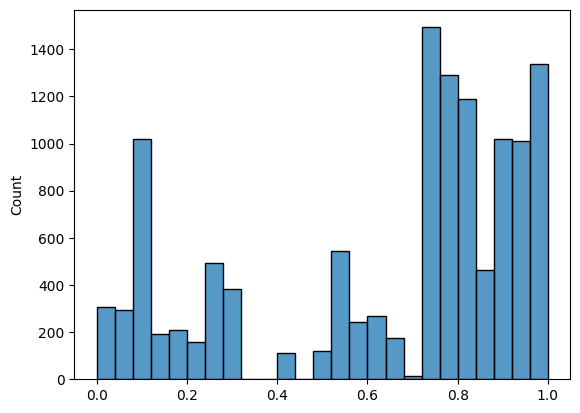

In [146]:
import seaborn as sns
sns.histplot(all_cell_time)

In [147]:
export_cell_time(load_cellDancer, all_cell_time, 'Gastrulation_combined.csv')

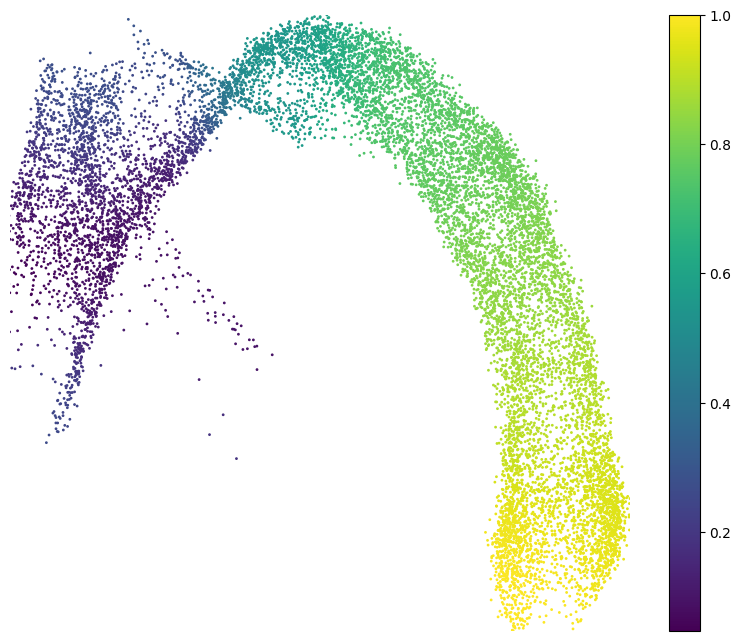

In [329]:
neigh = NearestNeighbors(n_neighbors = 10, radius=1, n_jobs=mp.cpu_count()-1)
neigh.fit(embedding)

A = neigh.radius_neighbors_graph(embedding)

B = all_cell_time*(A.toarray())

cell_time_radius = [np.mean(B[i][B[i]!=0]) for i in range(len(B))]

new_time = cell_time_radius/np.max(cell_time_radius)

fig,ax = plt.subplots(figsize=(10,8))
plt.scatter(embedding[:,0],embedding[:,1], c=new_time, s = 1, alpha =1)
plt.axis('off')
#plt.clim(0, 5)

plt.xlim([min(embedding[sampling_ixs,0]), max(embedding[sampling_ixs,0])])
plt.ylim([min(embedding[sampling_ixs,1]), max(embedding[sampling_ixs,1])])
plt.colorbar()
plt.show()

In [235]:
#cellid_time = np.vstack((range(len(all_cell_time)),all_cell_time)).T

df = pd.DataFrame(all_cell_time, columns = ['pseudotime'])
df.to_csv('pseudo_time_Gastrulation_combined.csv', index=True)

In [323]:
#cellid_time = np.vstack((range(len(all_cell_time)),all_cell_time)).T

df = pd.DataFrame(new_time, columns = ['pseudotime'])
df.to_csv('pseudo_time_Gastrulation_combined_NN_radius1_smooth.csv', index=True)

In [149]:
export_cell_time(load_cellDancer, all_cell_time, 'pseudo_time_Gastrulation_combined_10NN_smooth.csv')

In [468]:
cell_fate_tuned = cell_clustering_tuning(cell_embedding, cell_clusters)

In [469]:
neigh = NearestNeighbors(n_neighbors=1, radius=10, n_jobs=mp.cpu_count()-1)
neigh.fit(embedding[sampling_ixs])
A = neigh.kneighbors_graph(embedding)

B = A.toarray()
cell_fate_10nn = np.array([collections.Counter(B[i][B[i]!=0]*cell_fate_tuned[B[i]!=0]).most_common()[0][0] 
                           for i in range(len(B))], dtype=int)


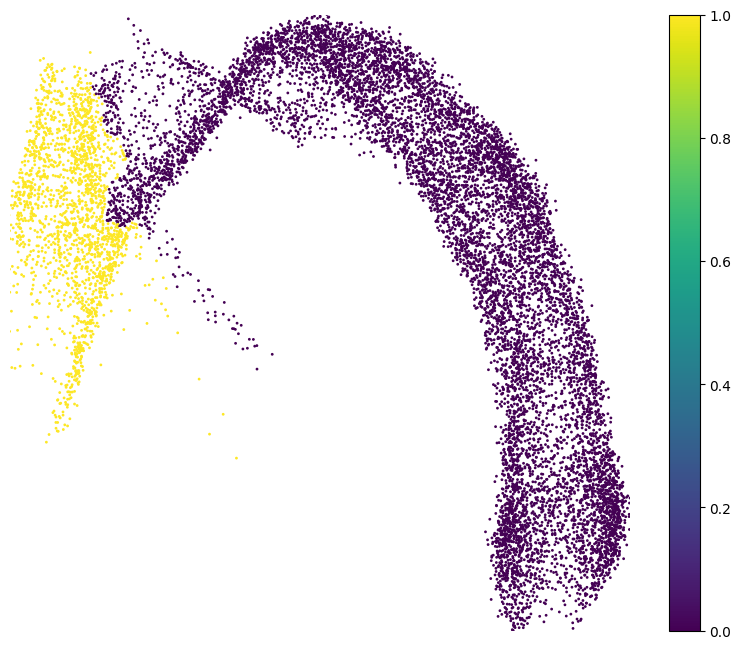

In [470]:
fig,ax = plt.subplots(figsize=(10,8))
plt.scatter(embedding[:,0],embedding[:,1], c=cell_fate_10nn, s = 1, alpha =1)
plt.axis('off')

plt.xlim([min(embedding[sampling_ixs,0]), max(embedding[sampling_ixs,0])])
plt.ylim([min(embedding[sampling_ixs,1]), max(embedding[sampling_ixs,1])])
plt.colorbar()
plt.show()

In [488]:
data = np.vstack((range(len(cell_fate_10nn)), cell_fate_10nn, new_time)).T

In [489]:
df = pd.DataFrame(data, columns = ['index', 'traj_cluster', 'pseudotime'])
df = df.astype({"index": int, "traj_cluster": int, "pseudotime": float})
df.to_csv('pseudo_time_Gastrulation_combined.csv', index=False)

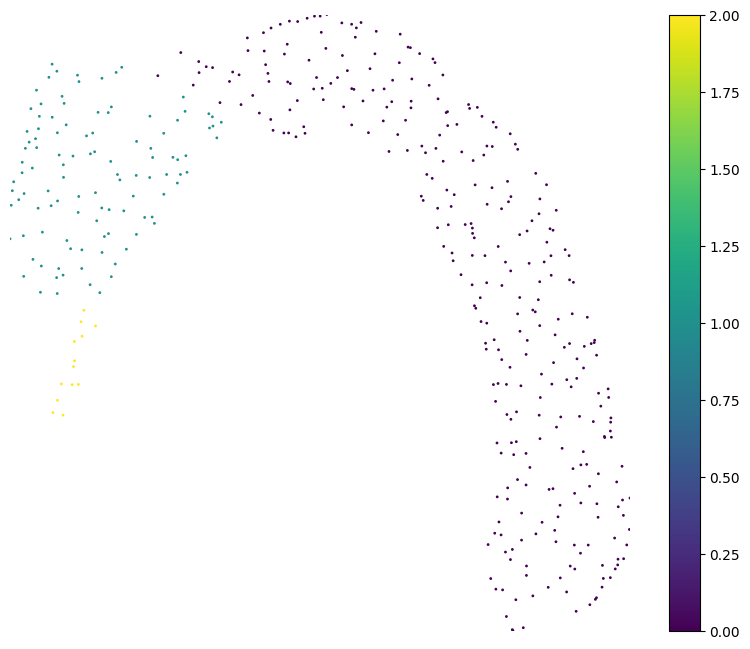

In [415]:
fig,ax = plt.subplots(figsize=(10,8))
plt.scatter(embedding[sampling_ixs,0],embedding[sampling_ixs,1], c=cell_fate_major, s = 1, alpha =1)
plt.axis('off')
#plt.clim(0, 5)

plt.xlim([min(embedding[sampling_ixs,0]), max(embedding[sampling_ixs,0])])
plt.ylim([min(embedding[sampling_ixs,1]), max(embedding[sampling_ixs,1])])
plt.colorbar()
plt.show()